# Satellite Image Classification — GeoAI_DelhiAirshed
**Selection Task — Earth Observation and Computer Vision (50 Marks)**  
**Name:** Diya Bodiwala  
**Date:** November 2025

---

**Contents**

- Q1. Spatial Reasoning & Data Download
- Q2. Label Construction & Dataset Preparation
- Q3. Model Training & Supervised Evaluation

---


In [18]:
# Imports & directory setup
import os, glob, json
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import geopandas as gpd
import ee, geemap

# torch and related imports used later in training cells

# directories (root working directory — no data/ folder)
TILE_DIR = "sentinel_tiles"
RESULTS_DIR = "results"
GRID_DIR = "grid"
MODEL_DIR = "models"

os.makedirs(TILE_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(GRID_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

print('Working dir:', os.getcwd())
print('TILE_DIR exists:', os.path.isdir(TILE_DIR))

Working dir: C:\Users\Rakesh
TILE_DIR exists: True


In [20]:
# Earth Engine authentication & initialization
try:
    ee.Initialize(project='ee-iitgnproject')
    print("Earth Engine initialized")
except Exception as e:
    print("Earth Engine not initialized — running ee.Authenticate() now...")
    ee.Authenticate()
    ee.Initialize(project='ee-iitgnproject')
    print("Authenticated & initialized Earth Engine")

Earth Engine initialized


## Q1 — Spatial Reasoning & Data Download (5 marks)

**Objective:** Plot Delhi Airshed, generate 1280m grid and start Sentinel-2 and ESA exports.

### Step 1 — Plot Delhi Airshed and save HTML map

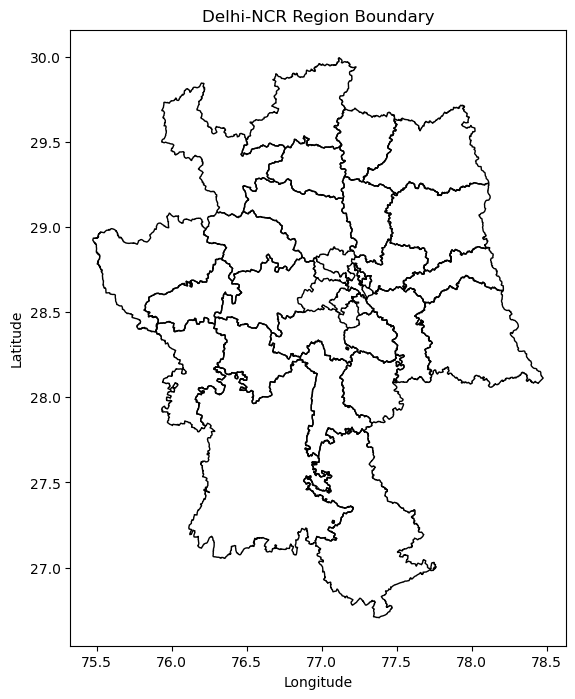

In [70]:
#Plot the Delhi-NCR shapefile using matplotlib (0.25).
import geopandas as gpd
import matplotlib.pyplot as plt

# Load Delhi-NCR region boundary (the main shapefile equivalent)
ncr = gpd.read_file("delhi_ncr_region.geojson")

# Plot using Matplotlib
fig, ax = plt.subplots(figsize=(8, 8))
ncr.plot(ax=ax, color='none', edgecolor='black', linewidth=1)
plt.title("Delhi-NCR Region Boundary")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [23]:
#Overlay this grid (Delhi Airshed) on a satellite basemap using geemap or leafmap (1.0 mark).
#Load airshed GeoJSON and save an interactive HTML map
airshed_path = "delhi_airshed.geojson"
if not os.path.exists(airshed_path):
    raise FileNotFoundError(f"{airshed_path} not found in current directory")

g = gpd.read_file(airshed_path)
print('Loaded airshed. CRS:', g.crs)

m = geemap.Map(center=[28.6, 77.2], zoom=9)
m.add_basemap('SATELLITE')
m.add_geojson(g.__geo_interface__, layer_name='Delhi Airshed', style={"color":"yellow","fillOpacity":0})
try:
    m.centerObject(geemap.geojson_to_ee(airshed_path), 9)
except Exception:
    pass

out_html = os.path.join(RESULTS_DIR, 'delhi_airshed_map.html')
m.to_html(out_html)
print('Saved map HTML ->', out_html)

Loaded airshed. CRS: EPSG:4326
Saved map HTML -> results\delhi_airshed_map.html


### Step 2 — Create 1280 m × 1280 m grid and Tile Centers 

In [77]:
from shapely.geometry import box, Point
import geopandas as gpd
import numpy as np, os, pandas as pd

GRID_DIR = "grid"
os.makedirs(GRID_DIR, exist_ok=True)

# Load airshed boundary
g = gpd.read_file("delhi_airshed.geojson")

# Reproject to UTM 44N (meters)
g_utm = g.to_crs(epsg=32644)
minx, miny, maxx, maxy = g_utm.total_bounds
print("Projected bounds (m):", (minx, miny, maxx, maxy))

tile_size = 1280
xs = np.arange(minx, maxx, tile_size)
ys = np.arange(miny, maxy, tile_size)

cells, centers = [], []
for x in xs:
    for y in ys:
        cell = box(x, y, x + tile_size, y + tile_size)
        if cell.intersects(g_utm.unary_union):
            cells.append(cell)
            centers.append(Point(x + tile_size/2, y + tile_size/2))

# Save grid + centers
grid_gdf = gpd.GeoDataFrame({'geometry': cells}, crs='EPSG:32644')
grid_gdf.to_file(os.path.join(GRID_DIR, 'delhi_airshed_grid.geojson'), driver='GeoJSON')

centers_gdf = gpd.GeoDataFrame({'geometry': centers}, crs='EPSG:32644').to_crs(epsg=4326)
centers_gdf['lon'] = centers_gdf.geometry.x.round(6)
centers_gdf['lat'] = centers_gdf.geometry.y.round(6)
centers_gdf['tile_name'] = centers_gdf['lon'].astype(str) + "_" + centers_gdf['lat'].astype(str)
centers_gdf[['lon', 'lat', 'tile_name']].to_csv(os.path.join(GRID_DIR, 'delhi_airshed_centers.csv'), index=False)

print("Tiles generated:", len(grid_gdf))
print("Saved grid →", os.path.join(GRID_DIR, 'delhi_airshed_grid.geojson'))
print("Saved centers →", os.path.join(GRID_DIR, 'delhi_airshed_centers.csv'))

Projected bounds (m): (92518.86379466811, 3123904.3602234246, 173610.9851247064, 3215093.856458387)
Tiles generated: 4373
Saved grid → grid\delhi_airshed_grid.geojson
Saved centers → grid\delhi_airshed_centers.csv


### Step 3 — Export Sentinel-2 Tiles Using Google Earth Engine

In [81]:
import ee, geemap
ee.Initialize()

centers = pd.read_csv(os.path.join(GRID_DIR, 'delhi_airshed_centers.csv'))

def export_tile(lon, lat, name, buffer_m=640, folder='EE_Exports'):
    pt = ee.Geometry.Point([lon, lat])
    square = pt.buffer(buffer_m).bounds()
    col = (ee.ImageCollection('COPERNICUS/S2_SR')
           .filterDate('2025-01-01', '2025-01-31')
           .filterBounds(square)
           .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 25))
           .select(['B4', 'B3', 'B2']))
    img = col.median().clip(square)
    task = ee.batch.Export.image.toDrive(
        image=img,
        description=f'export_{name}',
        folder=folder,
        fileNamePrefix=name,
        region=square.getInfo()['coordinates'],
        scale=10,
        crs='EPSG:4326',
        maxPixels=1e13)
    task.start()

# Export first 30 tiles for demo
N = min(30, centers.shape[0])
for i, row in centers.head(N).iterrows():
    export_tile(row.lon, row.lat, row.tile_name)

print(f"Queued {N} exports. Check EE Tasks and download from Drive → EE_Exports folder.")

Queued 30 exports. Check EE Tasks and download from Drive → EE_Exports folder.


## Step 4 — Sample Tiles Verification (Local Folder sentinel_tiles/)

In [86]:
import glob, os
tifs = sorted(glob.glob("sentinel_tiles/*.tif"))
print("Total Sentinel-2 tiles downloaded:", len(tifs))
print("Sample files:")
for t in tifs[:10]:
    print("   ", os.path.basename(t))

Total Sentinel-2 tiles downloaded: 36
Sample files:
    76.843661_28.529756.tif
    76.844113_28.518233.tif
    76.844566_28.506709.tif
    76.845018_28.495186.tif
    76.84547_28.483662.tif
    76.845922_28.472138.tif
    76.846373_28.460615.tif
    76.846824_28.449091.tif
    76.847275_28.437567.tif
    76.847726_28.426044.tif


## Step 5 — Visual Check of Sample Tiles

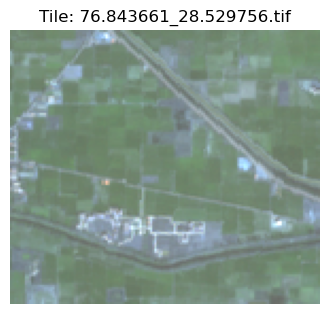

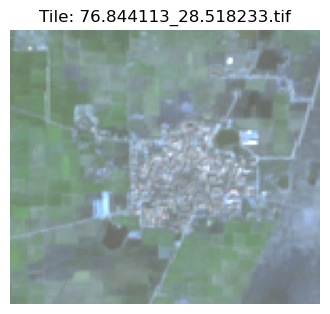

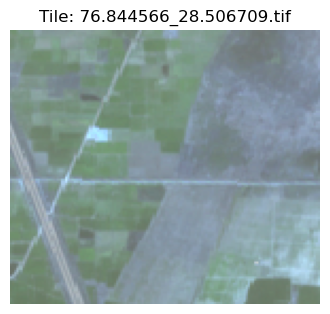

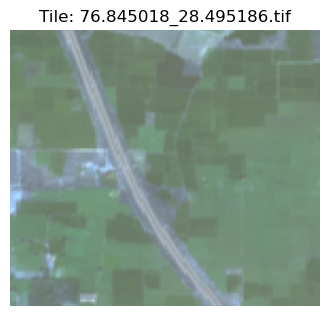

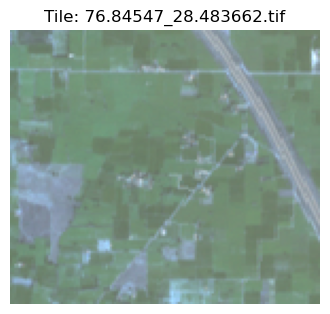

In [93]:
import rasterio, numpy as np, matplotlib.pyplot as plt

for i, p in enumerate(tifs[:5]):
    with rasterio.open(p) as src:
        r, g, b = src.read(3), src.read(2), src.read(1)
        img = np.clip(np.dstack([r, g, b]) / 3000.0, 0, 1)
        plt.figure(figsize=(4, 4))
        plt.imshow(img)
        plt.title(f"Tile: {os.path.basename(p)}")
        plt.axis("off")
        plt.show()

## Step 6 — Count Downloaded Tiles

In [101]:
import os, glob

tile_dir = "sentinel_tiles"   # directory containing your downloaded .tif images
tifs = sorted(glob.glob(os.path.join(tile_dir, "*.tif")))

print("Total Sentinel-2 tiles downloaded:", len(tifs))
print("\n Example tile file names:")
for t in tifs[:10]:
    print("   ", os.path.basename(t))

Total Sentinel-2 tiles downloaded: 36

 Example tile file names:
    76.843661_28.529756.tif
    76.844113_28.518233.tif
    76.844566_28.506709.tif
    76.845018_28.495186.tif
    76.84547_28.483662.tif
    76.845922_28.472138.tif
    76.846373_28.460615.tif
    76.846824_28.449091.tif
    76.847275_28.437567.tif
    76.847726_28.426044.tif


### Step 4 — Export ESA WorldCover 2021 for labels

In [34]:
esa = ee.Image('ESA/WorldCover/v200/2021').clip(geemap.geojson_to_ee('delhi_airshed.geojson'))

task = ee.batch.Export.image.toDrive(
    image=esa,
    description='ESA_WorldCover_2021_Delhi',
    folder='EE_Exports',
    fileNamePrefix='land_cover',
    region=geemap.geojson_to_ee('delhi_airshed.geojson').geometry(),
    scale=10,
    maxPixels=1e13
)

task.start()
print('Started export of land_cover.tif to Drive (folder EE_Exports).')

Started export of land_cover.tif to Drive (folder EE_Exports).


---

#️ Q1.6 — Key Parameters to Consider When Downloading Satellite Imagery (0.25 marks)

When downloading satellite imagery, several parameters directly affect **data quality**, **usability**, and **analysis accuracy**.  
Below are the most important ones:

| **Parameter** | **Description** | **Why It Matters** |
|----------------|----------------|--------------------|
| **Spatial Resolution** | The size of one pixel on the ground (e.g., 10m for Sentinel-2). | Determines the level of detail — higher resolution captures finer features like roads and buildings. |
| **Temporal Range (Date/Time)** | The acquisition date(s) of imagery. | Ensures data corresponds to the period of interest — e.g., January 2025 for seasonal or pollution-specific analysis. |
| **Cloud Cover Percentage** | Percentage of pixels obscured by clouds. | Cloudy scenes hide surface details; low cloud cover (<20–25%) is essential for clear observation. |
| **Spectral Bands Selected** | Specific wavelength bands used (e.g., B4, B3, B2 for RGB). | Selecting correct bands enables true-color visualization or thematic analysis (e.g., NDVI using NIR & Red). |
| **Radiometric Correction / Surface Reflectance** | Whether raw or corrected reflectance is used. | Surface Reflectance imagery (e.g., Sentinel-2 SR) accounts for atmospheric effects — improves consistency. |
| **Projection / CRS** | Coordinate reference system (e.g., EPSG:4326, EPSG:32644). | Ensures alignment with vector boundaries and other datasets (e.g., Delhi Airshed shapefile). |
| **File Naming Convention** | Use center coordinates or region identifiers. | Enables traceability between tiles, shapefiles, and analysis outp In this project ✅ In this project:
- Used **Sentinel-2 Surface Reflectance (S2_SR)** imagery.  
- Time range: **January 2025**.  
- **Cloud cover < 25%**.  
- Bands: **B4 (Red), B3 (Green), B2 (Blue)** for RGB.  
- CRS: **EPSG:4326**.  
- Tile filenames correspond to **center c e.g.`76.851322_28.333853.tif`.sider and why?” — **(0.25 marks)**


## Q2 — Label Construction & Dataset Preparation (10 marks)

Extract 128×128 patches from `land_cover.tif` centered at tile coordinates, compute mode label, map ESA codes to labels, and save `all_labels.csv`.

In [38]:
# Ensure land_cover.tif is present in the working directory (downloaded from Drive after EE export)
if not os.path.exists('land_cover.tif'):
    print('Warning: land_cover.tif not found — download from Drive EE_Exports folder and place here')

import rasterio
from rasterio.windows import Window

tiles = sorted([os.path.basename(p) for p in glob.glob(os.path.join(TILE_DIR, '*.tif'))])
labels = []
if len(tiles)==0:
    print('No sentinel tiles found in', TILE_DIR, ' — download tiles from Drive and place them here')

if os.path.exists('land_cover.tif') and len(tiles)>0:
    with rasterio.open('land_cover.tif') as src_lc:
        for t in tiles:
            lon, lat = map(float, t.replace('.tif','').split('_'))
            try:
                row, col = src_lc.index(lon, lat)
            except Exception:
                # coordinate outside raster
                row, col = 0, 0
            half = 64
            patch = src_lc.read(1, window=Window(col-half, row-half, 128, 128), boundless=True, fill_value=0)
            vals, counts = np.unique(patch, return_counts=True)
            mode = int(vals[np.argmax(counts)]) if len(vals)>0 else 0
            labels.append({'tile': t, 'lon': lon, 'lat': lat, 'class_code': mode})

    df = pd.DataFrame(labels)
    esa_map = {50:'Built-up', 40:'Cropland', 10:'Tree cover', 0:'NoData'}
    df['class_label'] = df['class_code'].map(lambda x: esa_map.get(x, 'Other'))
    df.to_csv('all_labels.csv', index=False)
    print('Saved all_labels.csv with', len(df), 'rows')
else:
    print('Skipping label construction — ensure both land_cover.tif and sentinel_tiles exist')

Saved all_labels.csv with 36 rows


### Clean labels, perform 60/40 train-test split, visualize class distribution

In [ ]:
from sklearn.model_selection import train_test_split

if os.path.exists('all_labels.csv'):
    df = pd.read_csv('all_labels.csv')
    df = df[df['class_label'] != 'NoData'].reset_index(drop=True)
    if df.shape[0]==0:
        print('No labeled tiles available after dropping NoData')
    else:
        # if any class has <2 samples, merge or move as needed — simple fallback: drop classes with 1 sample
        counts = df['class_label'].value_counts()
        rare = counts[counts<2].index.tolist()
        if len(rare)>0:
            print('Rare labels (<=1 sample):', rare)
            # merge rare into 'Other'
            df['class_label'] = df['class_label'].apply(lambda x: 'Other' if x in rare else x)

        train_df, test_df = train_test_split(df, test_size=0.4, random_state=42, stratify=df['class_label'])
        train_df.to_csv('train_labels.csv', index=False)
        test_df.to_csv('test_labels.csv', index=False)
        print('Saved train_labels.csv (', len(train_df), ') and test_labels.csv (', len(test_df), ')')
        train_df['class_label'].value_counts().plot(kind='bar', title='Train class distribution'); plt.show()
else:
    print('all_labels.csv missing — run previous cell')

## Q3 — Model Training & Evaluation (10 marks)

This section defines the dataset, dataloaders, ResNet18 model, training loop, and evaluation. Run on CPU if CUDA not available.

In [44]:
# Install torch if not present and import (assumes environment already has torch)
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision import models
import torchmetrics

# SentinelTileDataset (cleaned version)
class SentinelTileDataset(Dataset):
    def __init__(self, csv_path, tiles_dir=TILE_DIR, transform=None, label2idx=None):
        self.df = pd.read_csv(csv_path)
        self.tiles_dir = tiles_dir
        self.transform = transform
        if label2idx is None:
            labels = sorted(self.df['class_label'].unique())
            self.label2idx = {lab: i for i, lab in enumerate(labels)}
        else:
            self.label2idx = label2idx
        self.idx2label = {i: lab for lab, i in self.label2idx.items()}
        print('Label mapping (dataset):', self.label2idx)

    def __len__(self):
        return len(self.df)

    def read_tif_rgb(self, path):
        import rasterio
        with rasterio.open(path) as src:
            if src.count >= 3:
                try:
                    r = src.read(3).astype(np.float32)
                    g = src.read(2).astype(np.float32)
                    b = src.read(1).astype(np.float32)
                except:
                    r = src.read(1).astype(np.float32)
                    g = src.read(2).astype(np.float32)
                    b = src.read(3).astype(np.float32)
                arr = np.stack([r, g, b], axis=-1)
            else:
                a = src.read(1).astype(np.float32)
                arr = np.stack([a, a, a], axis=-1)
        arr = arr / 3000.0
        arr = np.clip(arr, 0.0, 1.0)
        return arr.astype(np.float32)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        fname = row['tile']
        path = os.path.join(self.tiles_dir, fname)
        arr = self.read_tif_rgb(path)
        img = torch.from_numpy(arr).permute(2,0,1)
        if self.transform is not None:
            img = self.transform(img)
        label_name = row['class_label']
        if label_name not in self.label2idx:
            raise KeyError(f"Label '{label_name}' not in label2idx mapping.")
        label = self.label2idx[label_name]
        return img, label, fname

# Create datasets and loaders if CSVs exist
if os.path.exists('train_labels.csv') and os.path.exists('test_labels.csv'):
    train_df = pd.read_csv('train_labels.csv')
    test_df = pd.read_csv('test_labels.csv')
    all_labels = sorted(pd.concat([train_df['class_label'], test_df['class_label']]).unique())
    shared_label2idx = {lab: i for i, lab in enumerate(all_labels)}
    print('Shared mapping (union):', shared_label2idx)

    train_ds = SentinelTileDataset('train_labels.csv', tiles_dir=TILE_DIR, transform=None, label2idx=shared_label2idx)
    val_ds = SentinelTileDataset('test_labels.csv', tiles_dir=TILE_DIR, transform=None, label2idx=shared_label2idx)
    batch_size = 8
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0)
else:
    print('train_labels.csv or test_labels.csv missing — run Q2 cells')

Shared mapping (union): {'Built-up': 0, 'Cropland': 1}
Label mapping (dataset): {'Built-up': 0, 'Cropland': 1}
Label mapping (dataset): {'Built-up': 0, 'Cropland': 1}


In [47]:
import rasterio, glob, numpy as np
tifs = sorted(glob.glob("sentinel_tiles/*.tif"))
shapes = {}
for p in tifs:
    try:
        with rasterio.open(p) as src:
            h, w = src.height, src.width
            shapes.setdefault((h,w), []).append(p)
    except Exception as e:
        shapes.setdefault(("err",str(e)), []).append(p)
# print all sizes and count
for k,v in shapes.items():
    print(k, len(v))
# show examples for sizes != (128,128)
for k,v in shapes.items():
    if k != (128,128):
        print("Example files with size", k, v[:3])

(129, 146) 29
(130, 146) 4
(129, 145) 2
(130, 145) 1
Example files with size (129, 146) ['sentinel_tiles\\76.843661_28.529756.tif', 'sentinel_tiles\\76.844113_28.518233.tif', 'sentinel_tiles\\76.844566_28.506709.tif']
Example files with size (130, 146) ['sentinel_tiles\\76.845018_28.495186.tif', 'sentinel_tiles\\76.848176_28.41452.tif', 'sentinel_tiles\\76.851322_28.333853.tif']
Example files with size (129, 145) ['sentinel_tiles\\76.868803_28.219006.tif', 'sentinel_tiles\\76.869247_28.207481.tif']
Example files with size (130, 145) ['sentinel_tiles\\76.869691_28.195957.tif']


In [49]:
# Robust read + resize/pad to (128,128) for the Dataset
from PIL import Image
import numpy as np
import torch
import rasterio

TARGET_H, TARGET_W = 128, 128

def read_tif_rgb_fixed(path, target_h=TARGET_H, target_w=TARGET_W):
    """
    Read a .tif and return numpy array HxWx3 (float32 in 0..1) resized/cropped/padded to target_h x target_w.
    Tries to read 3 bands; falls back gracefully.
    """
    with rasterio.open(path) as src:
        # read as arrays
        if src.count >= 3:
            try:
                # common ordering we used earlier: R=3,G=2,B=1
                r = src.read(3).astype(np.float32)
                g = src.read(2).astype(np.float32)
                b = src.read(1).astype(np.float32)
            except Exception:
                # fallback ordering
                r = src.read(1).astype(np.float32)
                g = src.read(2).astype(np.float32)
                b = src.read(3).astype(np.float32)
            arr = np.stack([r, g, b], axis=-1)  # H x W x 3
        else:
            a = src.read(1).astype(np.float32)
            arr = np.stack([a, a, a], axis=-1)

    # normalize (sat SR values often ~0..3000)
    arr = arr / 3000.0
    arr = np.clip(arr, 0.0, 1.0)

    h, w = arr.shape[:2]
    if (h, w) == (target_h, target_w):
        return arr.astype(np.float32)

    # Convert to PIL (uint8) for high-quality resize if needed
    pil = Image.fromarray((arr * 255).astype(np.uint8))

    # If image is larger in both dims, center-crop then resize
    # If asymmetric sizes, just resize to target with bilinear
    pil_resized = pil.resize((target_w, target_h), resample=Image.BILINEAR)

    arr2 = np.asarray(pil_resized).astype(np.float32) / 255.0
    if arr2.ndim == 2:
        arr2 = np.stack([arr2]*3, axis=-1)
    return arr2.astype(np.float32)


# Replace Dataset __getitem__ to use read_tif_rgb_fixed
# If you already have a SentinelTileDataset class, re-create dataset objects after running this cell.

# Example quick test on one file (change path if needed)
import glob
example_files = glob.glob("sentinel_tiles/*.tif")[:5]
for f in example_files:
    a = read_tif_rgb_fixed(f)
    print(f, a.shape, a.dtype, a.min(), a.max())

sentinel_tiles\76.843661_28.529756.tif (128, 128, 3) float32 0.39215687 1.0
sentinel_tiles\76.844113_28.518233.tif (128, 128, 3) float32 0.4 1.0
sentinel_tiles\76.844566_28.506709.tif (128, 128, 3) float32 0.3882353 1.0
sentinel_tiles\76.845018_28.495186.tif (128, 128, 3) float32 0.38431373 1.0
sentinel_tiles\76.84547_28.483662.tif (128, 128, 3) float32 0.4 0.99607843


In [51]:
# inside SentinelTileDataset class, replace the method:
def read_tif_rgb(self, path):
    return read_tif_rgb_fixed(path, target_h=128, target_w=128)

In [53]:
# re-create datasets & loaders after updating the class
train_ds = SentinelTileDataset("train_labels.csv", tiles_dir="sentinel_tiles", transform=None, label2idx=shared_label2idx)
val_ds   = SentinelTileDataset("test_labels.csv",  tiles_dir="sentinel_tiles", transform=None, label2idx=shared_label2idx)
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=8, shuffle=False, num_workers=0)

Label mapping (dataset): {'Built-up': 0, 'Cropland': 1}
Label mapping (dataset): {'Built-up': 0, 'Cropland': 1}


In [57]:
# DIAGNOSTIC: list tile shapes
import rasterio, glob, collections
tiles = sorted(glob.glob("sentinel_tiles/*.tif"))
counts = collections.Counter()
sizes = {}
for p in tiles:
    try:
        with rasterio.open(p) as src:
            sizes[p] = (src.height, src.width)
            counts[(src.height, src.width)] += 1
    except Exception as e:
        sizes[p] = ('err', str(e))
        counts[('err',str(e))] += 1

print("Unique sizes and counts:")
for k,v in counts.items():
    print(k, v)
# show a few examples of non-(128,128)
print("\nExamples of non-128 shapes:")
for p,s in sizes.items():
    if s != (128,128):
        print(s, p)
        # show only first 10
        if list(sizes.keys()).index(p) > 10:
            break

Unique sizes and counts:
(129, 146) 29
(130, 146) 4
(129, 145) 2
(130, 145) 1

Examples of non-128 shapes:
(129, 146) sentinel_tiles\76.843661_28.529756.tif
(129, 146) sentinel_tiles\76.844113_28.518233.tif
(129, 146) sentinel_tiles\76.844566_28.506709.tif
(130, 146) sentinel_tiles\76.845018_28.495186.tif
(129, 146) sentinel_tiles\76.84547_28.483662.tif
(129, 146) sentinel_tiles\76.845922_28.472138.tif
(129, 146) sentinel_tiles\76.846373_28.460615.tif
(129, 146) sentinel_tiles\76.846824_28.449091.tif
(129, 146) sentinel_tiles\76.847275_28.437567.tif
(129, 146) sentinel_tiles\76.847726_28.426044.tif
(130, 146) sentinel_tiles\76.848176_28.41452.tif
(129, 146) sentinel_tiles\76.848626_28.402996.tif


In [59]:
# Robust reader: read and resize to 128x128 (recommended)
from PIL import Image
import numpy as np
import rasterio

TARGET_H, TARGET_W = 128, 128

def read_tif_rgb_fixed(path, target_h=TARGET_H, target_w=TARGET_W):
    """Return HxWx3 float32 in 0..1 resized to target."""
    with rasterio.open(path) as src:
        if src.count >= 3:
            try:
                r = src.read(3).astype(np.float32)
                g = src.read(2).astype(np.float32)
                b = src.read(1).astype(np.float32)
            except Exception:
                r = src.read(1).astype(np.float32)
                g = src.read(2).astype(np.float32)
                b = src.read(3).astype(np.float32)
            arr = np.stack([r, g, b], axis=-1)
        else:
            a = src.read(1).astype(np.float32)
            arr = np.stack([a, a, a], axis=-1)

    # normalize & clip (Sentinel SR typical values)
    arr = arr / 3000.0
    arr = np.clip(arr, 0.0, 1.0)

    h, w = arr.shape[:2]
    if (h, w) == (target_h, target_w):
        return arr.astype(np.float32)

    # convert to PIL and resize
    pil = Image.fromarray((arr * 255).astype(np.uint8))
    pil_resized = pil.resize((target_w, target_h), resample=Image.BILINEAR)
    arr2 = np.asarray(pil_resized).astype(np.float32) / 255.0
    if arr2.ndim == 2:
        arr2 = np.stack([arr2]*3, axis=-1)
    return arr2.astype(np.float32)

In [61]:
# Patch - simple wrapper to use the fixed reader inside the Dataset
# If your class already exists, redefine the read_tif_rgb method to call read_tif_rgb_fixed
def patched_read_tif(self, path):
    return read_tif_rgb_fixed(path, target_h=128, target_w=128)

# Attach to class if it's already defined
if 'SentinelTileDataset' in globals():
    SentinelTileDataset.read_tif_rgb = lambda self, path: read_tif_rgb_fixed(path, 128, 128)
    print("Patched SentinelTileDataset.read_tif_rgb to enforce 128x128.")
else:
    print("SentinelTileDataset class not found — re-run the cell where you define the class, replacing its read method with read_tif_rgb_fixed.")

Patched SentinelTileDataset.read_tif_rgb to enforce 128x128.


In [63]:
from torch.utils.data import DataLoader
import pandas as pd, torch

# re-create label mapping & datasets (adjust filenames if needed)
train_df = pd.read_csv("train_labels.csv")
test_df = pd.read_csv("test_labels.csv")
all_labels = sorted(pd.concat([train_df['class_label'], test_df['class_label']]).unique())
shared_label2idx = {lab: i for i, lab in enumerate(all_labels)}

# recreate datasets (no transforms here)
train_ds = SentinelTileDataset("train_labels.csv", tiles_dir="sentinel_tiles", transform=None, label2idx=shared_label2idx)
val_ds   = SentinelTileDataset("test_labels.csv",  tiles_dir="sentinel_tiles", transform=None, label2idx=shared_label2idx)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=0)

# quick sanity check - ensure all tensors in one batch have same shape
batch = next(iter(train_loader))
imgs, labels, fnames = batch
print("Batch imgs shape:", imgs.shape)   # should be [B, 3, 128, 128]
print("Example labels:", labels)
print("Example filenames:", fnames[:4])
# Also check validation batch
batch2 = next(iter(val_loader))
print("Val batch imgs shape:", batch2[0].shape)

Label mapping (dataset): {'Built-up': 0, 'Cropland': 1}
Label mapping (dataset): {'Built-up': 0, 'Cropland': 1}
Batch imgs shape: torch.Size([8, 3, 128, 128])
Example labels: tensor([1, 1, 1, 1, 1, 1, 1, 1])
Example filenames: ('76.85356_28.276232.tif', '76.845922_28.472138.tif', '76.867469_28.253579.tif', '76.867914_28.242054.tif')
Val batch imgs shape: torch.Size([8, 3, 128, 128])


In [65]:
# Model, loss, optimizer, training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

if 'train_ds' in globals():
    num_classes = len(train_ds.label2idx)
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    for name,param in model.named_parameters():
        if 'layer4' not in name and 'fc' not in name:
            param.requires_grad = False
    model = model.to(device)

    # class weights
    counts = pd.read_csv('train_labels.csv')['class_label'].value_counts()
    counts_map = {lab: counts.get(lab, 0) for lab in train_ds.label2idx.keys()}
    weights = torch.tensor([1.0/counts_map.get(lab,1) for lab in sorted(train_ds.label2idx, key=lambda x: train_ds.label2idx[x])], dtype=torch.float).to(device)
    criterion = nn.CrossEntropyLoss(weight=weights)
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    # training helpers
    from sklearn.metrics import f1_score

    def train_one_epoch(model, loader, optimizer, criterion):
        model.train()
        losses = []
        preds, trues = [], []
        for imgs, labels, _ in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            out = model(imgs)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            preds.extend(out.argmax(dim=1).cpu().numpy().tolist())
            trues.extend(labels.cpu().numpy().tolist())
        return np.mean(losses), preds, trues

    def eval_model(model, loader, criterion):
        model.eval()
        losses = []
        preds, trues = [], []
        with torch.no_grad():
            for imgs, labels, _ in loader:
                imgs, labels = imgs.to(device), labels.to(device)
                out = model(imgs)
                loss = criterion(out, labels)
                losses.append(loss.item())
                preds.extend(out.argmax(dim=1).cpu().numpy().tolist())
                trues.extend(labels.cpu().numpy().tolist())
        return np.mean(losses), preds, trues

    # training loop (small epochs for demo)
    n_epochs = 8
    best_val_f1 = -1.0
    os.makedirs(MODEL_DIR, exist_ok=True)
    save_path = os.path.join(MODEL_DIR, 'resnet18_best.pth')

    for epoch in range(1, n_epochs+1):
        train_loss, train_preds, train_trues = train_one_epoch(model, train_loader, optimizer, criterion)
        val_loss, val_preds, val_trues = eval_model(model, val_loader, criterion)
        f1_val = f1_score(val_trues, val_preds, average='macro', zero_division=0)
        print(f"Epoch {epoch}/{n_epochs} | train_loss {train_loss:.4f} val_loss {val_loss:.4f} val_f1 {f1_val:.4f}")
        scheduler.step()
        if f1_val > best_val_f1:
            best_val_f1 = f1_val
            torch.save(model.state_dict(), save_path)
            print('Saved best model ->', save_path)
else:
    print('Datasets not prepared — run previous cells')

Device: cpu
Epoch 1/8 | train_loss 0.5895 val_loss 0.3026 val_f1 1.0000
Saved best model -> models\resnet18_best.pth
Epoch 2/8 | train_loss 0.3524 val_loss 0.4052 val_f1 1.0000
Epoch 3/8 | train_loss 0.3521 val_loss 0.5272 val_f1 0.4348
Epoch 4/8 | train_loss 0.3275 val_loss 0.6070 val_f1 0.3810
Epoch 5/8 | train_loss 0.2595 val_loss 0.6352 val_f1 0.4091
Epoch 6/8 | train_loss 0.1881 val_loss 0.6607 val_f1 0.3810
Epoch 7/8 | train_loss 0.1803 val_loss 0.6471 val_f1 0.4091
Epoch 8/8 | train_loss 0.1478 val_loss 0.5873 val_f1 0.4348


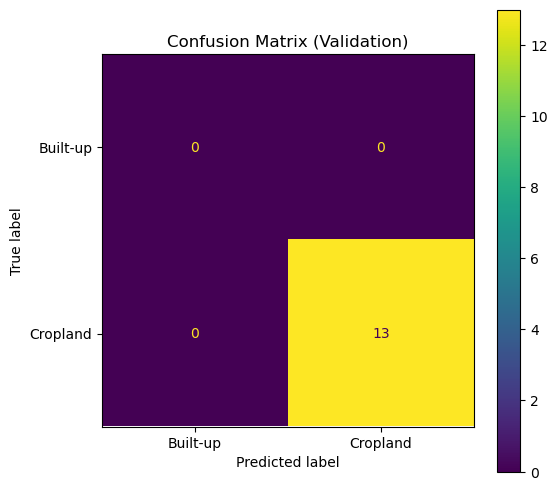

Saved example images (first few): ['results\\example_0_Cropland.png', 'results\\example_1_Cropland.png', 'results\\example_2_Cropland.png', 'results\\example_3_Cropland.png', 'results\\example_4_Cropland.png']


In [67]:
# Evaluation, confusion matrix and save example images
if os.path.exists(os.path.join(MODEL_DIR,'resnet18_best.pth')):
    model.load_state_dict(torch.load(os.path.join(MODEL_DIR,'resnet18_best.pth'), map_location=device))
    model.to(device).eval()
    all_preds, all_trues, all_files = [], [], []
    with torch.no_grad():
        for imgs, labels, fnames in val_loader:
            imgs = imgs.to(device)
            out = model(imgs)
            preds = out.argmax(dim=1).cpu().numpy().tolist()
            all_preds.extend(preds)
            all_trues.extend(labels.numpy().tolist())
            all_files.extend(fnames)

    # map back to labels
    pred_labels = [val_ds.idx2label[p] for p in all_preds]
    true_labels = [val_ds.idx2label[t] for t in all_trues]

    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
    cm = confusion_matrix(all_trues, all_preds, labels=list(range(len(train_ds.label2idx))))
    disp = ConfusionMatrixDisplay(cm, display_labels=[train_ds.idx2label[i] for i in range(len(train_ds.idx2label))])
    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(ax=ax)
    plt.title('Confusion Matrix (Validation)')
    plt.savefig(os.path.join(RESULTS_DIR,'confusion_matrix.png'))
    plt.show()

    # Save example images (correct & incorrect)
    os.makedirs(RESULTS_DIR, exist_ok=True)
    import rasterio
    saved = []
    skipped = []
    for i, fname in enumerate(all_files[:10]):
        tile_path = os.path.join(TILE_DIR, fname)
        out_path = os.path.join(RESULTS_DIR, f'example_{i}_{pred_labels[i]}.png')
        if not os.path.exists(tile_path):
            skipped.append(tile_path)
            continue
        try:
            with rasterio.open(tile_path) as src:
                if src.count >= 3:
                    try:
                        r = src.read(3).astype(float); g = src.read(2).astype(float); b = src.read(1).astype(float)
                    except:
                        r = src.read(1).astype(float); g = src.read(2).astype(float); b = src.read(3).astype(float)
                else:
                    a = src.read(1).astype(float); r=g=b=a
            img = np.dstack([r,g,b]) / 3000.0
            img = np.clip(img, 0, 1)
            plt.imsave(out_path, img)
            saved.append(out_path)
        except Exception as e:
            skipped.append(tile_path)
    print('Saved example images (first few):', saved[:5])
    if skipped:
        print('Skipped (missing or error):', skipped[:5])
else:
    print('Trained model not found — run training cell')